In [1]:
# External
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('mu2e.mplstyle')

# Internal
import decoder as dc
# Print all classes defined in decoder
print([name for name in dir(dc) if isinstance(getattr(dc, name), type)])

['EWTWriter', 'HitWriter', 'gr', 'header', 'hit', 'reader', 'status', 'subevent', 'tqdm']


In [2]:
!ls /scratch/mu2e/mu2ecrv_crv_scorrodi_v3_03_00/OutputData/ -trhl | tail

-rw-r----- 1 mu2ecrv mu2e 4.7M Jan 15 16:58 wb_test_065.bin
-rw-r----- 1 mu2ecrv mu2e 4.6M Jan 15 16:58 wb_test_066.bin
-rw-r----- 1 mu2ecrv mu2e 4.6M Jan 15 16:59 wb_test_067.bin
-rw-r----- 1 mu2ecrv mu2e 7.7M Jan 15 17:01 wb_test_068.bin
-rw-r----- 1 mu2ecrv mu2e  78M Jan 15 17:02 wb_test_069.bin
-rw-r----- 1 mu2ecrv mu2e 9.1K Jan 16 15:09 wb_test_60.bin
-rw-r----- 1 mu2ecrv mu2e 781K Jan 16 15:10 wb_test_070.bin
-rw-r----- 1 mu2ecrv mu2e 5.8G Jan 16 16:13 wb_test_071.bin
-rw-r----- 1 mu2ecrv mu2e 2.9M Jan 21 09:48 raw.mu2e.pulseInjection_cal_crv.trig_gr3_streamer.000025_000001_1.art
-rw-r----- 1 mu2ecrv mu2e 2.9M Jan 21 10:01 raw.mu2e.crv.wideband.KPP.000026_000001_1.art


In [3]:
def process_file(filename= "wb_test_037.bin"): 
    """
    Process binary file into DataFrame
    """
    reader = dc.reader(filename) # Initialise reader
    reader.raw = False # Set raw flag
    hit_writer = dc.HitWriter(n_samples=8) # Initialise hit writer
    reader.get(verbose=0, writer=hit_writer) # Read the file
    return hit_writer.get() # Return DataFrame

df = process_file()
display(df)

/scratch/mu2e/mu2ecrv_crv_scorrodi_v3_03_00/OutputData/wb_test_037.bin: 100%|▉| 


,EWT,channel,time,s0,s1,s2,s3,s4,s5,s6,s7
0,13,104,2255,-2,22,153,231,159,77,55,42
1,14,106,2650,29,98,116,60,17,6,5,-2
2,15,111,3336,-3,58,132,79,19,4,8,5
3,17,110,2766,0,80,142,109,71,59,37,15
4,26,88,519,-5,94,308,310,183,79,39,24
...,...,...,...,...,...,...,...,...,...,...,...
400920,1050741,98,3685,4,57,144,137,100,61,34,34
400921,1050744,124,2599,-2,91,372,486,357,180,86,55
400922,1050744,125,2599,-8,54,245,274,164,70,48,38
400923,1050750,114,840,16,55,249,353,252,142,119,116


In [4]:
# Build a channel map
def get_layers(df): 
    """"
    Assign layer based on channel number
    16 HDMI * 4 SiPMs = 64 
    Should be 16 channels x 4 layers 
    """
    # Get unique channel numbers and sort them
    channels = np.sort(df.channel.unique())
    # Arrange them by layer
    channel_array_4x16 = channels.reshape(-1, 16)
    print(f"4x16 channel array:\n{channel_array_4x16}\n")

    # Create the layer map
    channel_map = {}
    for layer, channels in enumerate(channel_array_4x16):
        for channel in channels:
            channel_map[channel] = layer

    # Add layer column to df
    df["layer"] = df.channel.map(channel_map)

    return df

df = get_layers(df)
display(df)

4x16 channel array:
[[ 64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79]
 [ 80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95]
 [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111]
 [112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127]]



,EWT,channel,time,s0,s1,s2,s3,s4,s5,s6,s7,layer
0,13,104,2255,-2,22,153,231,159,77,55,42,2
1,14,106,2650,29,98,116,60,17,6,5,-2,2
2,15,111,3336,-3,58,132,79,19,4,8,5,2
3,17,110,2766,0,80,142,109,71,59,37,15,2
4,26,88,519,-5,94,308,310,183,79,39,24,1
...,...,...,...,...,...,...,...,...,...,...,...,...
400920,1050741,98,3685,4,57,144,137,100,61,34,34,2
400921,1050744,124,2599,-2,91,372,486,357,180,86,55,3
400922,1050744,125,2599,-8,54,245,274,164,70,48,38,3
400923,1050750,114,840,16,55,249,353,252,142,119,116,3


In [12]:
def filter_samples(df, threshold=10):
    """
    Filter rows with samples below threshold
    """
    # Filter columns starting with 's' (samples)
    columns_to_mask = df.filter(like='s').columns
    # Create a mask where all 's' columns are >= threshold
    mask = (df[columns_to_mask] >= threshold).all(axis=1)
    # Apply mask
    df = df[mask]
    # Drop the NaN rows
    df = df.dropna()
    return df

df_skim = filter_samples(df, threshold=10)
# Display
display(df_skim)

,EWT,channel,time,s0,s1,s2,s3,s4,s5,s6,s7,layer
7,31,67,313,18,126,230,154,77,55,45,33,0
8,36,100,2902,21,91,149,111,63,42,32,21,2
14,50,74,612,37,96,147,92,54,56,41,20,0
17,53,114,1718,16,15,206,654,882,687,386,245,3
25,88,83,3826,10,92,329,348,198,101,74,52,1
...,...,...,...,...,...,...,...,...,...,...,...,...
400906,1050704,79,1386,25,98,192,148,90,63,47,35,0
400907,1050704,117,3335,52,121,139,113,94,80,58,38,3
400908,1050706,91,852,14,109,179,122,50,25,23,15,1
400916,1050730,83,1595,11,94,139,86,35,21,30,36,1


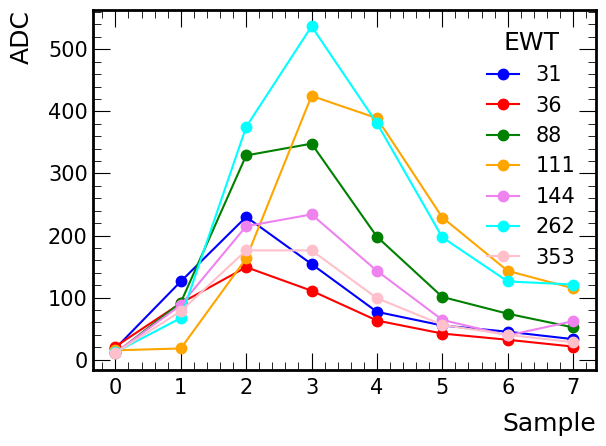

In [25]:
def plot_samples(df, n_rows=7):

    fig, ax = plt.subplots() # figsize=(10,6))
    for i_row in range(n_rows):
        plt.plot(
            df.iloc[i_row**2][["s%i" % i for i in range(8)]].values,
            '.',
            ms=15,
            label=df.iloc[i_row**2]["EWT"],
            linestyle="-"
        )
    plt.legend(loc="best", title="EWT")
    plt.ylabel("ADC")
    plt.xlabel("Sample")
    plt.tight_layout()
    plt.savefig("images/samples.png", dpi=300)
    plt.show()
    # plt.title(f"Samples > {threshold}")

plot_samples(df_skim)

In [13]:
def find_coincidences(df, min_layers=4):
    """
    Find EWTs with 4/4 layers hit
    The fancy lambda function stuff is from Claude, not sure if necessary
    """
    # First group by EWT and count unique layers hit in each event
    df_layers = df.groupby('EWT')['layer'].agg(['nunique', lambda x: list(sorted(set(x)))])
    df_layers.columns = ['num_layers', 'layers_hit'] # rename columns
    
    # Filter for coincidences 
    df_coincs = df_layers[df_layers["num_layers"] == min_layers]
    
    # Look at the results
    print(f"Total EWTs with layers hit: {len(df_layers)}")
    print(f"EWTs with {min_layers}/4 layers hit: {len(df_coincs)}")

    # Search full DataFrame 
    df_full_coincs = df[df['EWT'].isin(df_coincs.index)] 

    # Get layer counts 
    df_layer_counts = df_full_coincs.groupby(['EWT', 'layer']).size().unstack(fill_value=0)
    
    # Convert the rows to lists
    lists_layer_counts = df_layer_counts.apply(lambda row: list(row.values), axis=1)
    
    # Convert to back to DataFrame
    df_layer_counts = pd.DataFrame({
        'layer_counts': lists_layer_counts
    })
    
    # Now merge   
    df_coincs = df_coincs.merge(df_layer_counts, left_on='EWT', right_index=True)

    return df_coincs

df_coincs = find_coincidences(df_skim)

display(df_coincs)

Total EWTs with layers hit: 63796
EWTs with 4/4 layers hit: 22


,num_layers,layers_hit,layer_counts
EWT,,,
11461,4,"[0, 1, 2, 3]","[2, 2, 2, 2]"
69960,4,"[0, 1, 2, 3]","[2, 2, 2, 1]"
78417,4,"[0, 1, 2, 3]","[3, 1, 1, 2]"
123470,4,"[0, 1, 2, 3]","[1, 1, 1, 1]"
167582,4,"[0, 1, 2, 3]","[2, 2, 2, 2]"
195947,4,"[0, 1, 2, 3]","[1, 1, 1, 2]"
221195,4,"[0, 1, 2, 3]","[1, 1, 1, 2]"
227286,4,"[0, 1, 2, 3]","[1, 2, 2, 2]"
316927,4,"[0, 1, 2, 3]","[1, 1, 1, 1]"


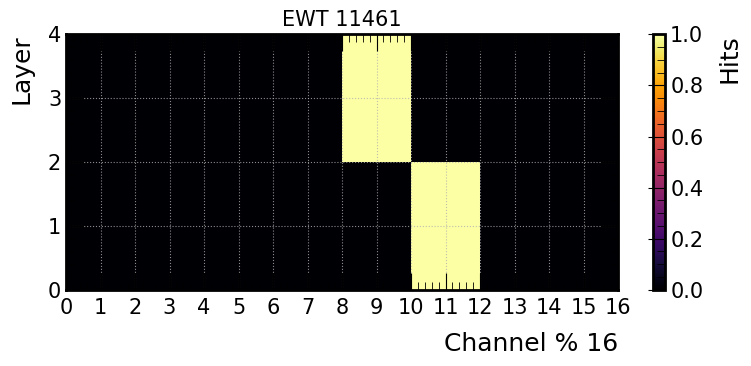

In [14]:
def display_ewt(df, ewt): 
    """
    Event display for one EWT
    """
    # Search for this EWT
    df_ewt = df[df.EWT == ewt]    
    
    # Create figure
    plt.figure(figsize=(8, 4))
    
    # Create 2D histogram
    plt.hist2d(df_ewt.channel % 16, df_ewt.layer, 
               bins=[16, 4], 
               range=[[0, 16], [0, 4]],
               cmap="inferno"
              )  
    
    plt.title(f"EWT {ewt}")
    plt.colorbar(label=f"Hits")
    plt.xlabel("Channel % 16")
    plt.ylabel("Layer")
    # Add grid 
    plt.xticks(range(0, 17, 1))
    plt.grid(True) 
    plt.tight_layout()
    plt.savefig(f"images/display_ewt_{ewt}.png", dpi=300)
    plt.show()
    plt.close()

ewt = df_coincs.index[0]  
display_ewt(df, ewt)

In [8]:
# ewt = df_coincs.index[0] 
# df_ewt = df[df.EWT == ewt]  
# display(df_ewt)
# ewt_time = df_ewt.time.values.astype(np.uint16)
# plt.hist(
#     ewt_time, 
#     bins=np.arange(np.min(ewt_time)-1, np.max(ewt_time)+1, 1),
#     histtype='step'
# );
# # plt.hist(df.time.values & 0xff);
# plt.xlabel("Timestamp")
# plt.ylabel("HIts")
# plt.tight_layout()

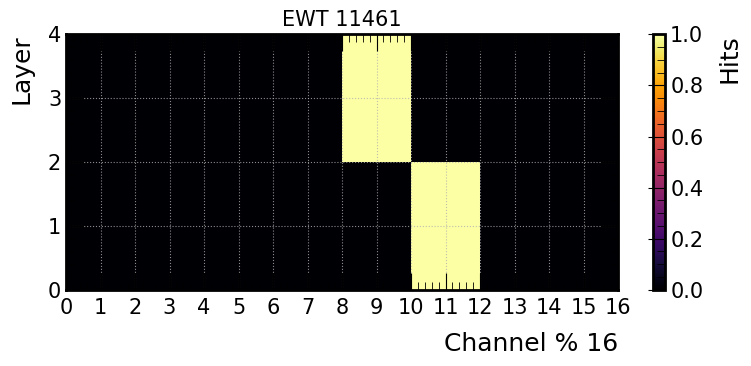

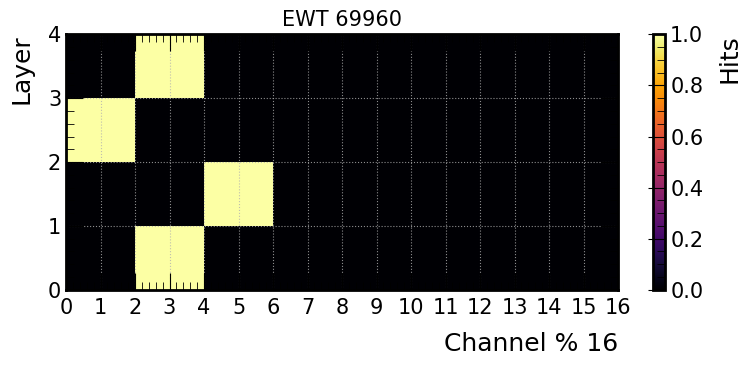

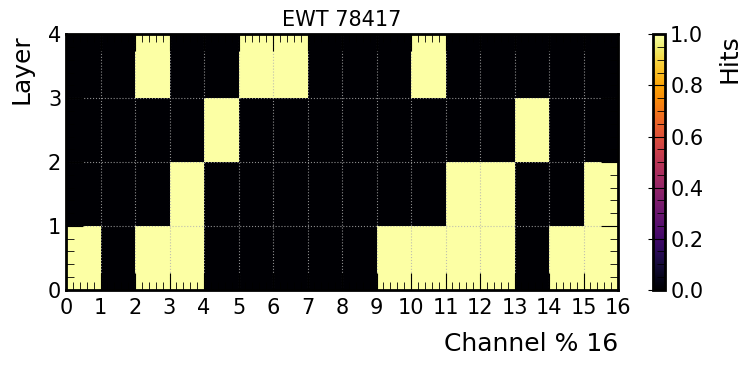

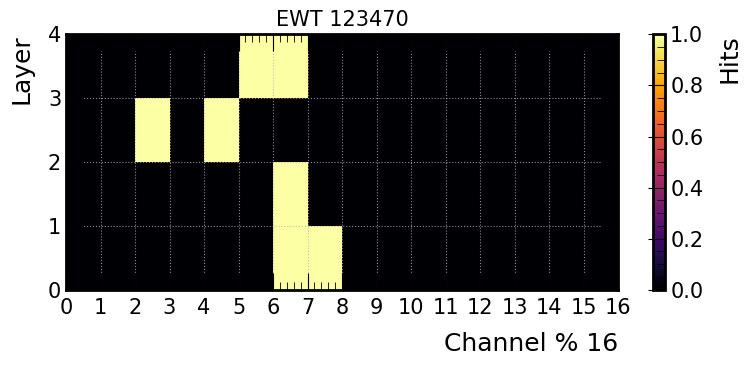

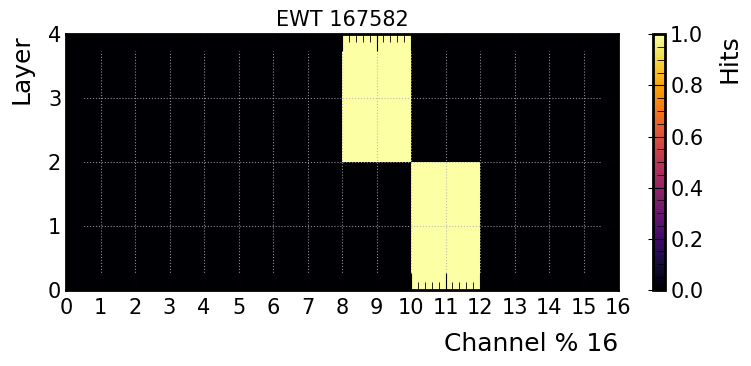

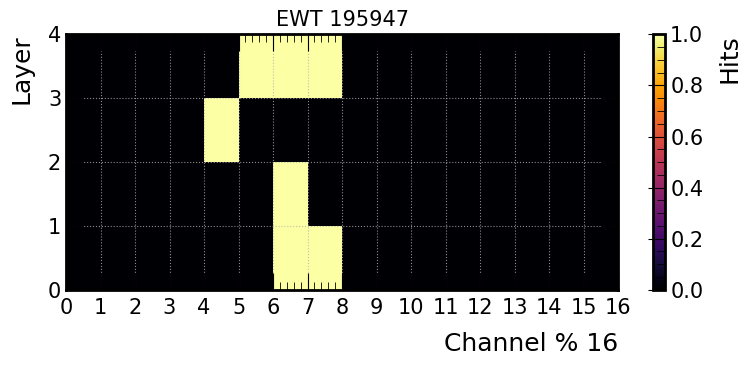

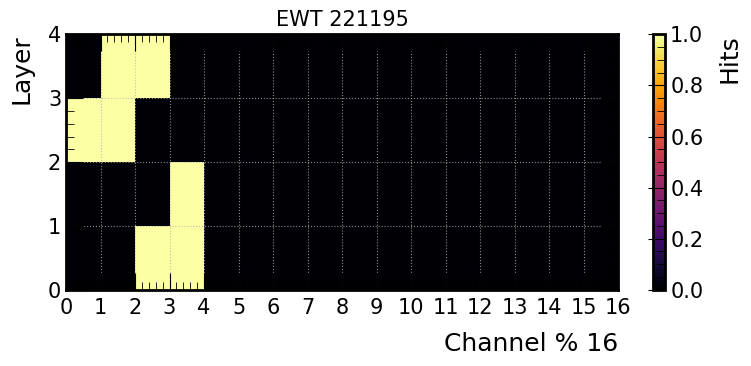

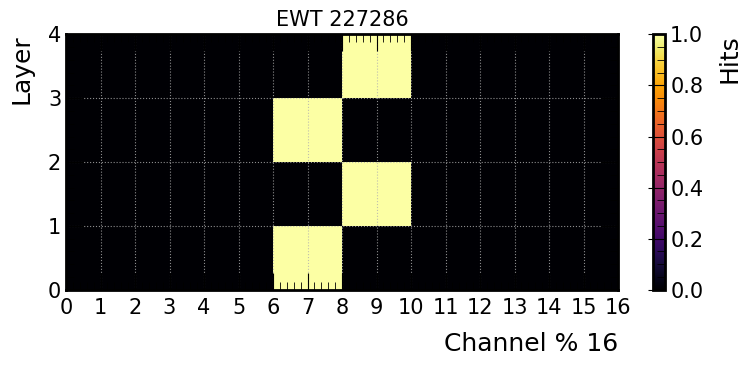

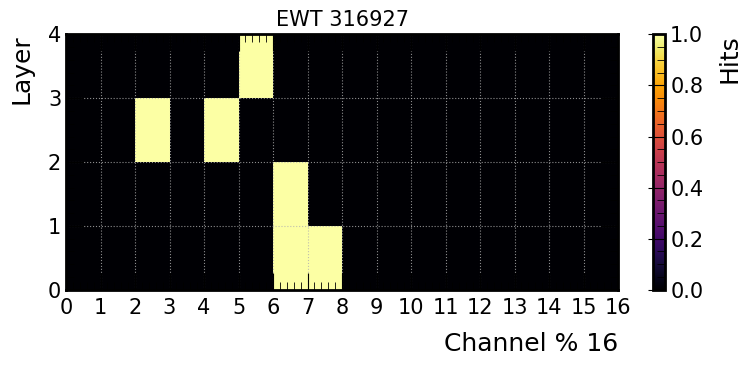

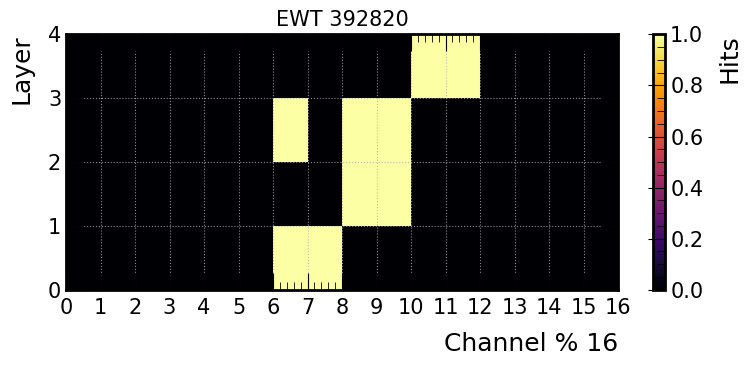

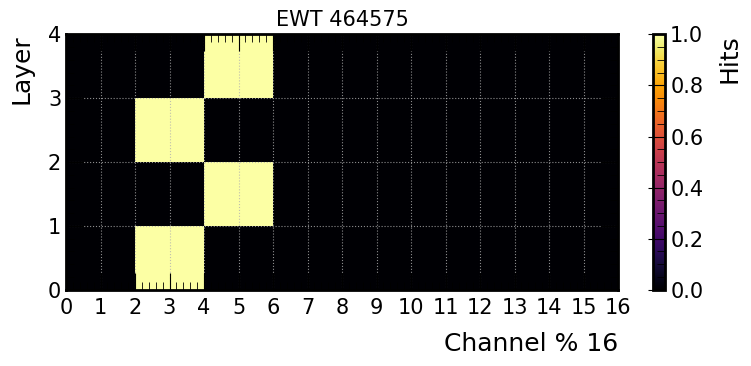

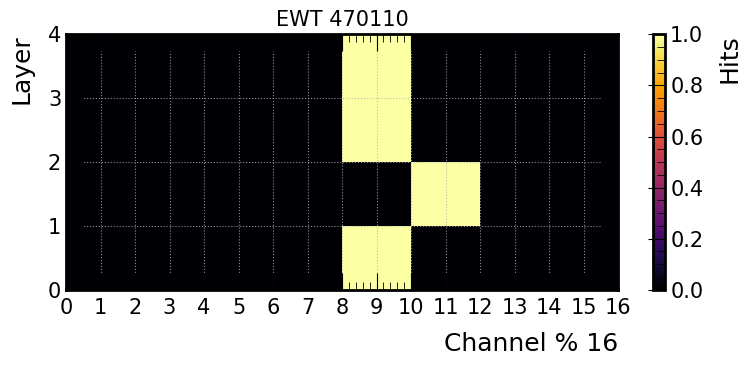

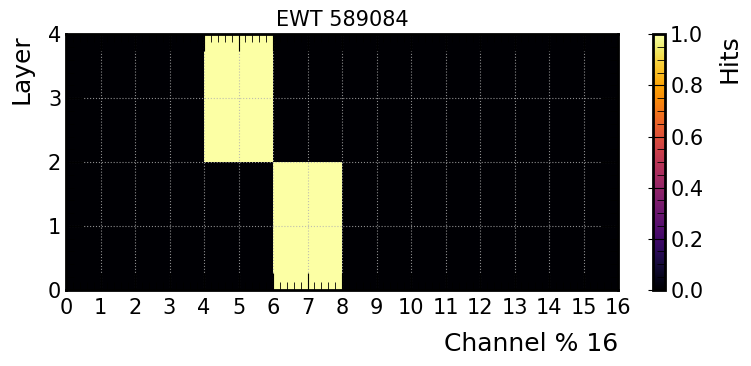

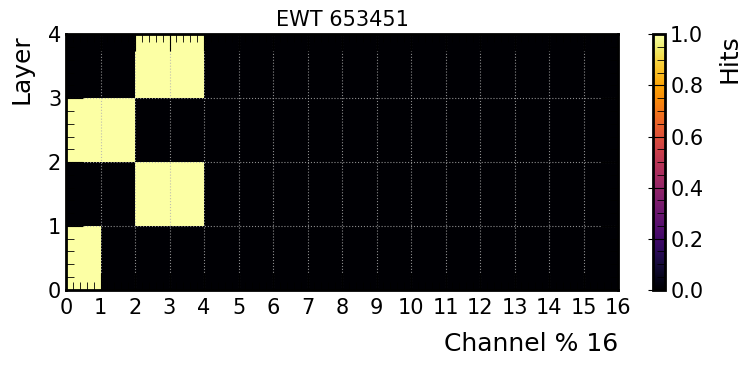

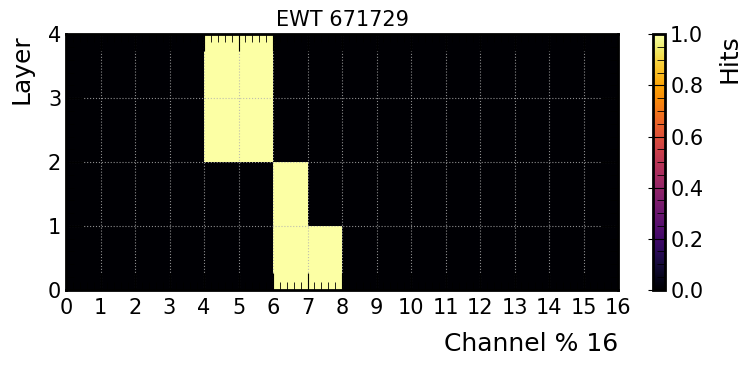

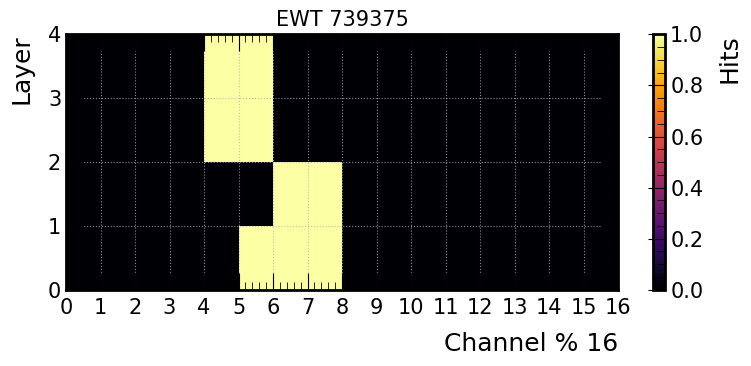

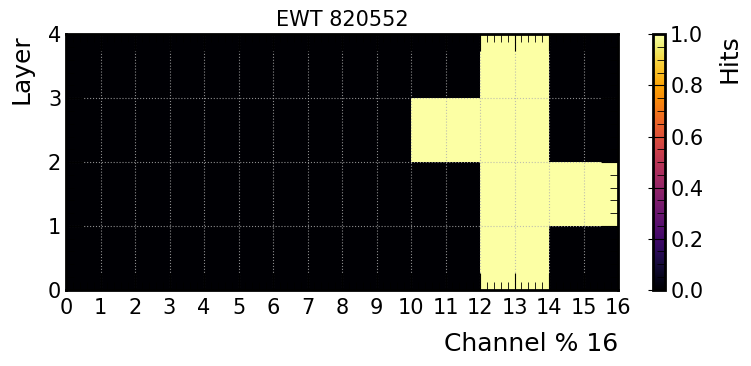

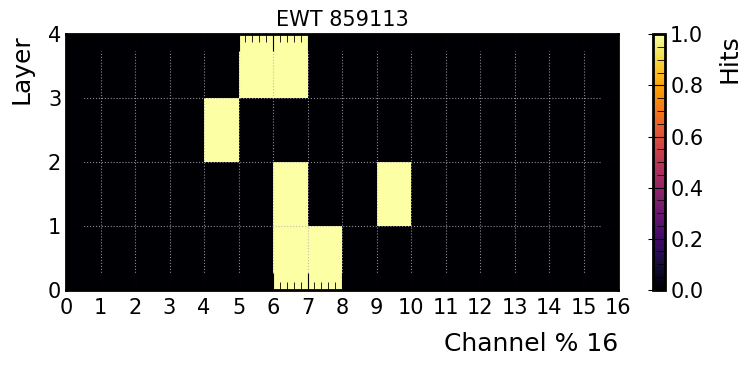

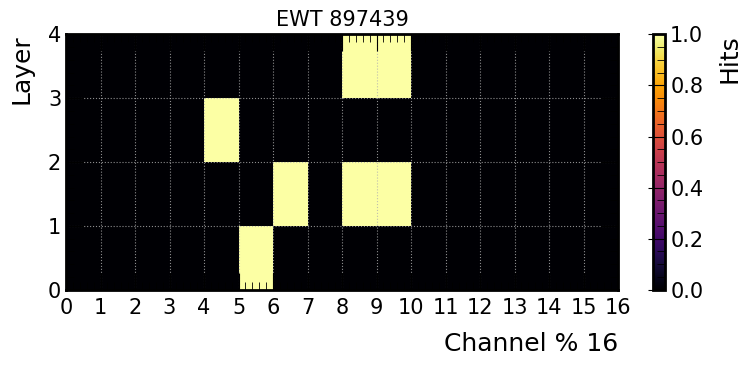

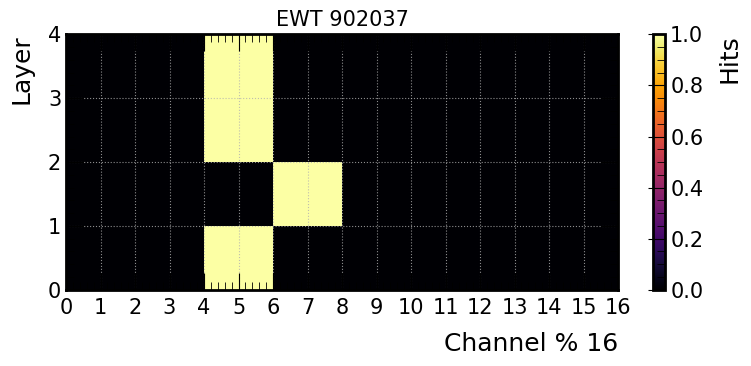

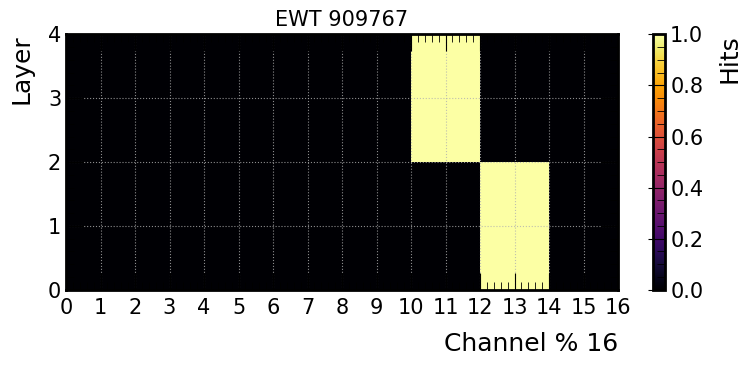

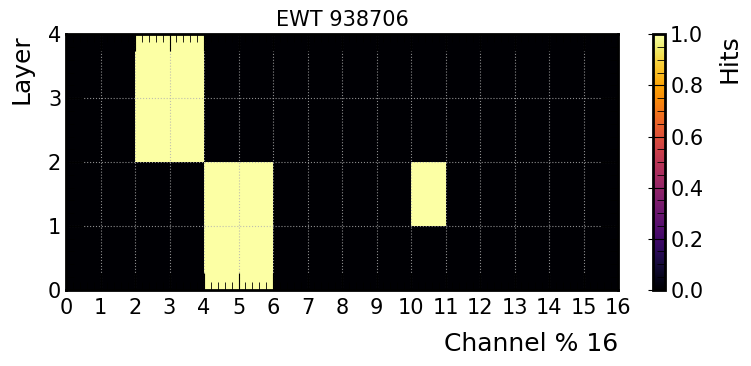

In [15]:
for i in range(22): 
    ewt = df_coincs.index[i]  
    display_ewt(df, ewt)